### GAN으로 새로운 패션아이템 생성

- Generative Adversarial Networks. 적대적 생성 신경망

- 차후 확인 - https://github.com/keon/3-min-pytorch/blob/master/09-%EA%B2%BD%EC%9F%81%ED%95%98%EB%A9%B0_%ED%95%99%EC%8A%B5%ED%95%98%EB%8A%94_GAN/gan.ipynb

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [4]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

- 생성자는 64차원의 랜덤한 텐서를 입력받아 이에 행렬곱(Linear)과 활성화 함수(ReLU, Tanh) 연산을 실행
- 생성자의 결과값은 784차원, Fashion MNIST 속의 이미지와 같은 차원의 텐서

In [5]:
# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())

- 판별자는 784차원의 텐서를 입력

In [6]:
# 판별자 (Discriminator)
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

- 생성자와 판별자 학습에 쓰일 오차 함수와 최적화 알고리즘 정의

In [7]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

- 모델 학습

In [8]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/500], d_loss: 0.0399, g_loss: 4.4891, D(x): 0.99, D(G(z)): 0.02
Epoch [1/500], d_loss: 0.0248, g_loss: 4.9957, D(x): 1.00, D(G(z)): 0.02
Epoch [2/500], d_loss: 0.0472, g_loss: 5.8745, D(x): 1.00, D(G(z)): 0.04
Epoch [3/500], d_loss: 0.1348, g_loss: 5.0470, D(x): 0.97, D(G(z)): 0.02
Epoch [4/500], d_loss: 0.0888, g_loss: 7.1841, D(x): 0.97, D(G(z)): 0.01
Epoch [5/500], d_loss: 0.1476, g_loss: 3.4895, D(x): 0.98, D(G(z)): 0.08
Epoch [6/500], d_loss: 0.1972, g_loss: 6.1447, D(x): 0.94, D(G(z)): 0.03
Epoch [7/500], d_loss: 0.3262, g_loss: 3.7658, D(x): 0.95, D(G(z)): 0.12
Epoch [8/500], d_loss: 0.2651, g_loss: 5.0383, D(x): 0.89, D(G(z)): 0.02
Epoch [9/500], d_loss: 0.1518, g_loss: 4.8187, D(x): 0.94, D(G(z)): 0.05
Epoch [10/500], d_loss: 0.1226, g_loss: 5.6730, D(x): 0.96, D(G(z)): 0.03
Epoch [11/500], d_loss: 0.1320, g_loss: 4.8487, D(x): 0.97, D(G(z)): 0.05
Epoch [12/500], d_loss: 0.1226, g_loss: 4.7524, D(x): 0.95, D(G(z)): 0.03
Epoch [13/500], d_loss: 0.3355, g_loss: 5.7588, 

In [9]:
D_cpu = D.to('cpu')

In [11]:
torch.save(D, './result/Discriminator.pt')

In [12]:
torch.save(G, './result/Generator.pt')

##### 생성결과물 확인

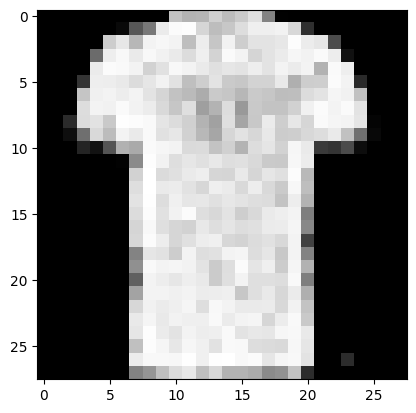

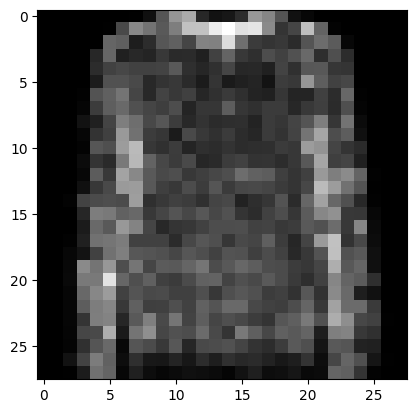

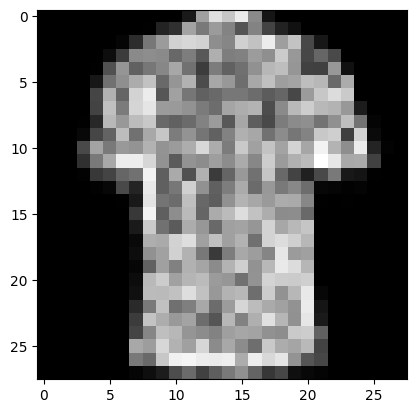

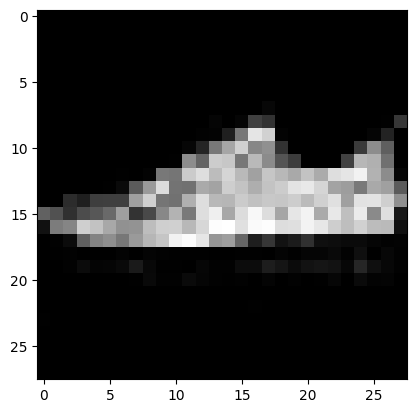

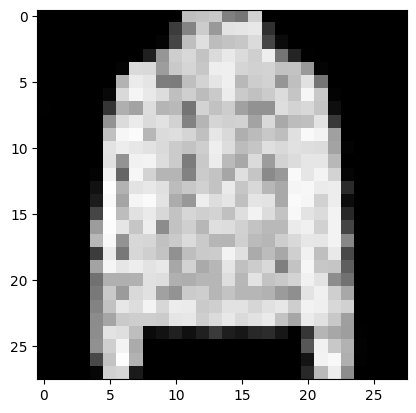

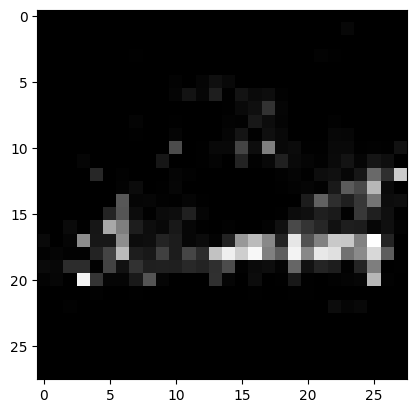

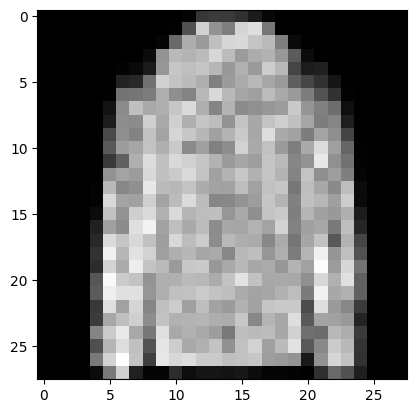

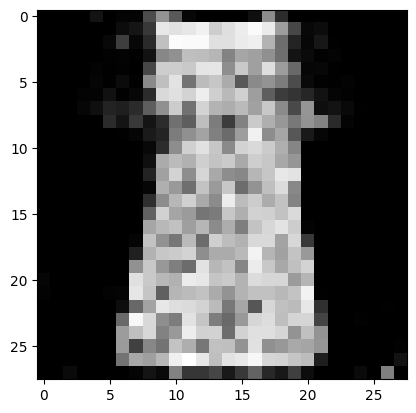

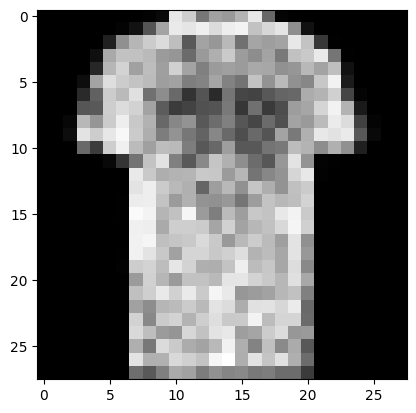

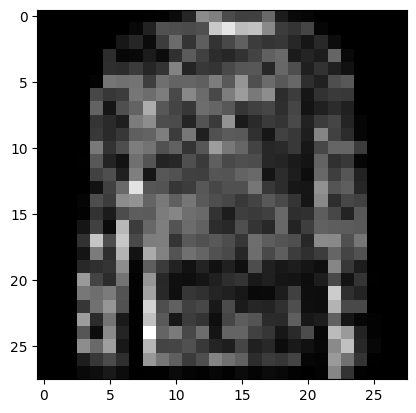

In [13]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()